In [16]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp
import seaborn as sns
import matplotlib.pyplot as plt

#### Tensorflow Scientific Computing

Vectorization

In [4]:
mats = tf.random.uniform(shape=[1000, 10, 10])
vecs = tf.random.uniform(shape=[1000, 10, 1])

def for_loop_solve():
    return np.array([tf.linalg.solve(mats[i, ...], vecs[i, ...]) for i in range(1000)])

def vectorized_solve():
    return tf.linalg.solve(mats, vecs) # Solves a system of linear equations

# Check Times
%timeit for_loop_solve()
%timeit vectorized_solve()

2024-01-17 00:26:24.940895: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x6bf9fe0


957 ms ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
560 µs ± 23.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


Hardware Acceleration

In [5]:
if tf.test.gpu_device_name() == '/device:GPU:0':
  print("Using a GPU")
else:
  print("Using a CPU")

Using a GPU


2024-01-17 00:29:57.471529: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-17 00:29:57.471627: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-17 00:29:57.471646: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-17 00:29:57.472194: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-01-17 00:29:57.472220: I tensorflow/core/common_runtime/gpu/gpu

Automatic Differentiation

In [7]:
a = tf.constant(np.pi)
b = tf.constant(np.e)

with tf.GradientTape() as tape: # Creates Gradient Tape context to record operations for autodiff
    tape.watch([a, b]) # Tells Gradient Tape to watch a and b for computations later to be used to compute gradients
    c = 0.5 * (a**2 + b**2) # A computation with a and b

grads = tape.gradient(c, [a, b])
print(grads[0]) # Gradient of c with respect to a
print(grads[1]) # Gradient of c with respect to b

tf.Tensor(3.1415927, shape=(), dtype=float32)
tf.Tensor(2.7182817, shape=(), dtype=float32)


#### Tensorflow Probability: Distributions
- `tfp.distributions.Distribution`

Simple Scalar Variate Distribution

In [12]:
from tensorflow_probability import distributions as tfd

# Standard Normal
normal = tfd.Normal(loc=0., scale=1.)
print(normal)

tfp.distributions.Normal("Normal", batch_shape=[], event_shape=[], dtype=float32)


tf.Tensor(
[ 0.47998077  1.4397283   0.35873488 -0.55072814 -0.08194008  0.8245697
  1.2814785  -1.5667653   1.4064567  -0.03387833], shape=(10,), dtype=float32)


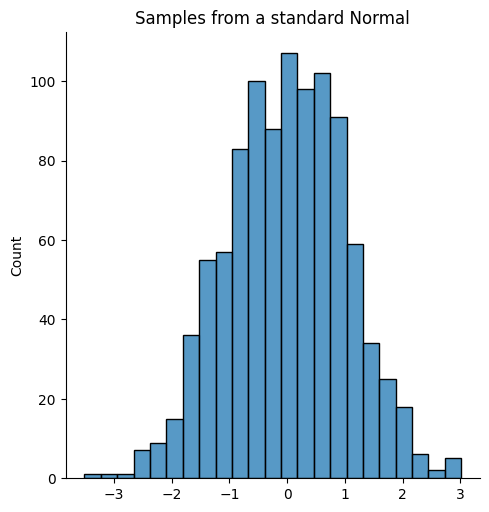

In [19]:
# Plot 1000 samples from standard normal

samples = normal.sample(1000)
print(samples[:10])
sns.displot(samples)
plt.title("Samples from a standard Normal")
plt.show()

In [20]:
# Compute log_prob of a point in the event space of normal
normal.log_prob(0.)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.9189385>

In [21]:
# Log prob of multiple points
normal.log_prob([-1., 0., 1.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-1.4189385, -0.9189385, -1.4189385], dtype=float32)>

Distributions and Batching

In [25]:
# Batch of 3 normals
normals = tfd.Normal([-2.5, 0., 2.5], 1.) # 3 normal distributions with 3 different means and the same standard deviation
print("Batch shape:", normals.batch_shape)
print("Event shape:", normals.event_shape)

Batch shape: (3,)
Event shape: ()


In [27]:
# Sampling across a batches
samples = normals.sample(1000)
samples.shape

TensorShape([1000, 3])

In [28]:
# More complicated sampling
normals.sample([10, 10, 10]).shape

TensorShape([10, 10, 10, 3])

In [29]:
# log_probs across a batch matching the length of the batch
print(normals.log_prob([-2.5, 0., 2.5]))

tf.Tensor([-0.9189385 -0.9189385 -0.9189385], shape=(3,), dtype=float32)


In [30]:
# log_probs across a batch for a single scalar value
print(normals.log_prob(0.))

tf.Tensor([-4.0439386 -0.9189385 -4.0439386], shape=(3,), dtype=float32)


In [34]:
# Examples of bad broadcasting
xs = np.linspace(-6, 6, 200)
try:
  normals.log_prob(xs)
except Exception as e:
  print("TFP error:", e.message)

try:
  np.zeros(200) + np.zeros(3)
except Exception as e:
  print("Numpy error:", e)

TFP error: {{function_node __wrapped__SquaredDifference_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:SquaredDifference] name: 
Numpy error: operands could not be broadcast together with shapes (200,) (3,) 


2024-01-17 01:31:21.959903: W tensorflow/core/framework/op_kernel.cc:1827] INVALID_ARGUMENT: required broadcastable shapes


In [36]:
# Working broadcasting
a = np.zeros([200, 1])
print('a', a.shape)
z = np.zeros(3)
print('z', z.shape)
a = a + np.zeros(3)
print('broadcast', a.shape)

a (200, 1)
z (3,)
broadcast (200, 3)


In [38]:
# Also working broadcasting
xs = np.linspace(-6, 6, 200)
print('xs', xs.shape)
xs = xs[..., np.newaxis]
print('xs', xs.shape)

lps = normals.log_prob(xs)
print("Broadcast log_prob shape:", lps.shape)

xs (200,)
xs (200, 1)
Broadcast log_prob shape: (200, 3)


/tmp/ipykernel_32638/2344786203.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples[:, i], kde=True, norm_hist=True)
/tmp/ipykernel_32638/2344786203.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples[:, i], kde=True, norm_hist=True)
/tmp/ipykernel_32638/2344786203.py:3: UserWarn

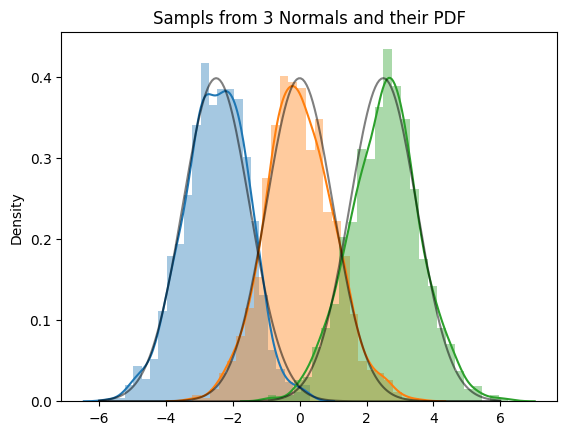

In [43]:
# Visualizing
for i in range(3):
    sns.distplot(samples[:, i], kde=True, norm_hist=True)

plt.plot(np.tile(xs, 3), normals.prob(xs), c='k', alpha=0.5)
plt.title('Sampls from 3 Normals and their PDF')
plt.show()

Vector-Variate Distribution

In [44]:
mvn = tfd.MultivariateNormalDiag(loc=[0., 0.], scale_diag=[1., 1.])
print("Batch shape:", mvn.batch_shape)
print("Event shape:", mvn.event_shape)

Batch shape: ()
Event shape: (2,)


In [45]:
samples = mvn.sample(1000)
print("Samples shape:", samples.shape)

Samples shape: (1000, 2)


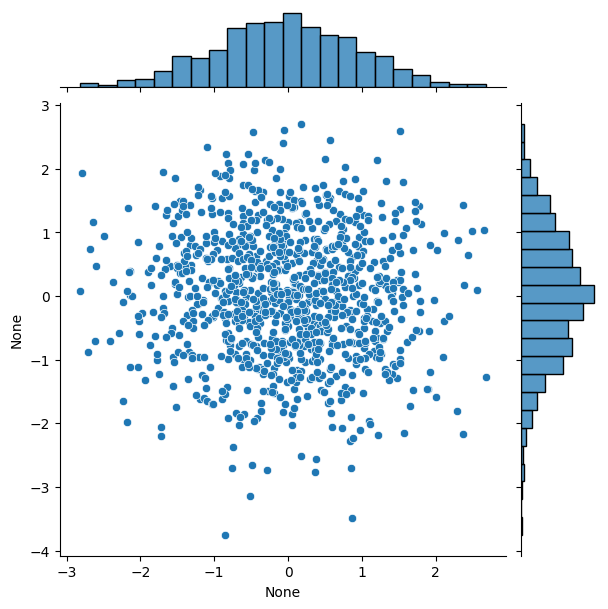

In [46]:
g = sns.jointplot(x=samples[:, 0], y=samples[:, 1], kind='scatter')
plt.show()

Matrix-Variate Distribution

In [47]:
lkj = tfd.LKJ(dimension=10, concentration=[1.5, 3.0])
print("Batch shape: ", lkj.batch_shape)
print("Event shape: ", lkj.event_shape)

Batch shape:  (2,)
Event shape:  (10, 10)


In [48]:
samples = lkj.sample()
print("Samples shape: ", samples.shape)

Samples shape:  (2, 10, 10)


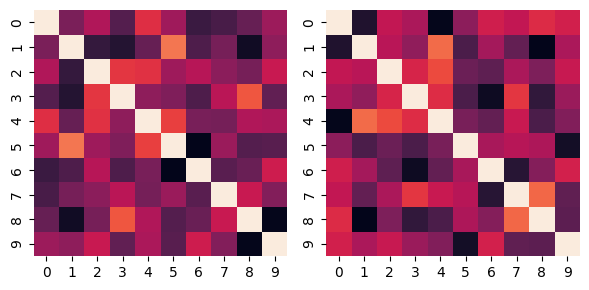

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
sns.heatmap(samples[0, ...], ax=axes[0], cbar=False)
sns.heatmap(samples[1, ...], ax=axes[1], cbar=False)
fig.tight_layout()
plt.show()

Gaussian Process

In [54]:
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic()
xs = np.linspace(-5., 5., 200).reshape([-1, 1])
gp = tfd.GaussianProcess(kernel, index_points=xs)
print("Batch shape:", gp.batch_shape)
print("Event shape:", gp.event_shape)

Batch shape: ()
Event shape: (200,)


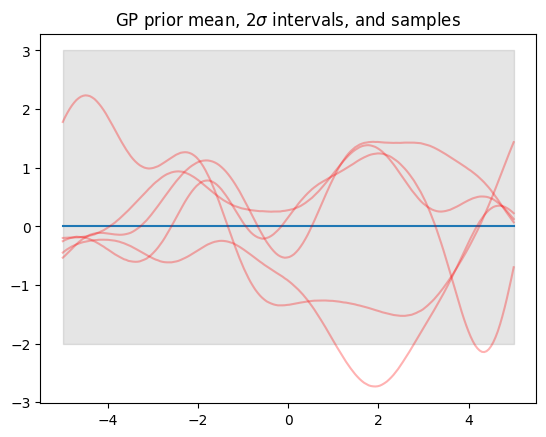

In [55]:
upper, lower = gp.mean() + [2+gp.stddev(), -2*gp.stddev()]
plt.plot(xs, gp.mean())
plt.fill_between(xs[..., 0], upper, lower, color='k', alpha=.1)
for _ in range(5):
  plt.plot(xs, gp.sample(), c='r', alpha=.3)
plt.title(r"GP prior mean, $2\sigma$ intervals, and samples")
plt.show()

GP Regression

In [56]:
obs_x = [[-3.], [0.], [2.]]  # Shape 3x1 (3 1-D vectors)
obs_y = [3., -2., 2.]        # Shape 3   (3 scalars)

gprm = tfd.GaussianProcessRegressionModel(kernel, xs, obs_x, obs_y)

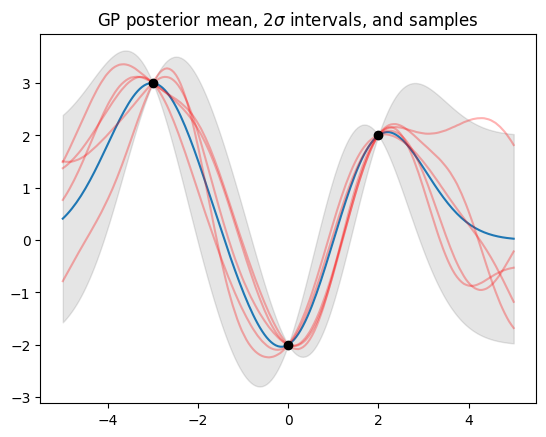

In [57]:
upper, lower = gprm.mean() + [2 * gprm.stddev(), -2 * gprm.stddev()]
plt.plot(xs, gprm.mean())
plt.fill_between(xs[..., 0], upper, lower, color='k', alpha=.1)
for _ in range(5):
  plt.plot(xs, gprm.sample(), c='r', alpha=.3)
plt.scatter(obs_x, obs_y, c='k', zorder=3)
plt.title(r"GP posterior mean, $2\sigma$ intervals, and samples")
plt.show()

#### Bijectors

- These mostly invertible smooth functions
- Found in `tfp.bijectors`
- They all have these functions: forward, inverse, and one of (forward_log_det_jacobian, inverse_log_det_jacobian)

Simple Bijector

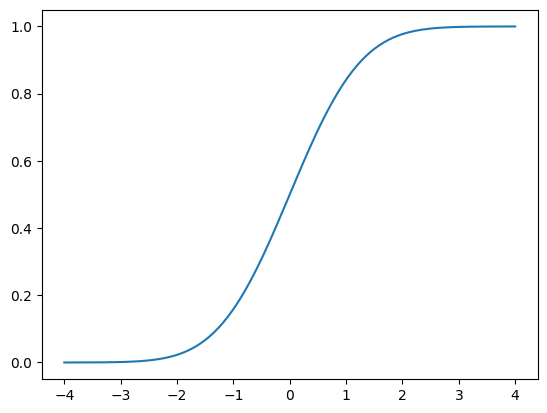

In [58]:
normal_cdf = tfp.bijectors.NormalCDF()
xs = np.linspace(-4., 4., 200)
plt.plot(xs, normal_cdf.forward(xs))
plt.show()

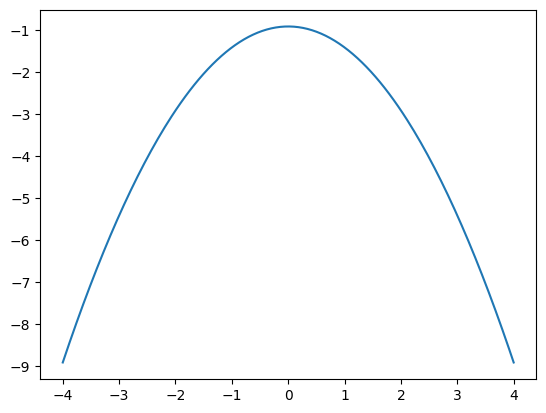

In [59]:
plt.plot(xs, normal_cdf.forward_log_det_jacobian(xs, event_ndims=0))
plt.show()

Bijector transforming a distribution

/tmp/ipykernel_32638/3389564558.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(samples, norm_hist=True, kde=False)


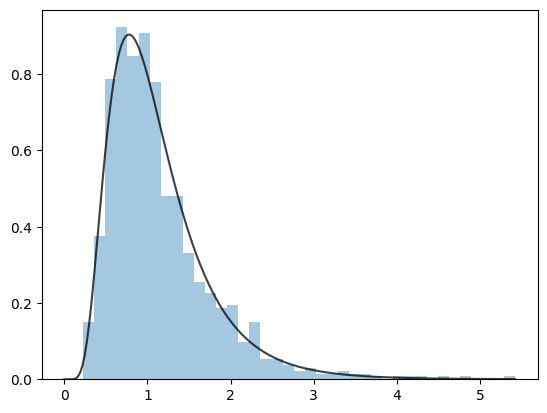

In [64]:
exp_bijector = tfp.bijectors.Exp()
log_normal = exp_bijector(tfd.Normal(0., .5))

samples = log_normal.sample(1000)
xs = np.linspace(1e-10, np.max(samples), 200)
sns.distplot(samples, norm_hist=True, kde=False)
plt.plot(xs, log_normal.prob(xs), c='k', alpha=.75)
plt.show()

Batching Bijectors

In [65]:
softplus = tfp.bijectors.Softplus(
  hinge_softness=[1., .5, .1])
print("Hinge softness shape:", softplus.hinge_softness.shape)

Hinge softness shape: (3,)


In [66]:
xs = np.linspace(-4., 4., 200)[..., np.newaxis]
ys = softplus.forward(xs)
print("Forward shape:", ys.shape)

Forward shape: (200, 3)


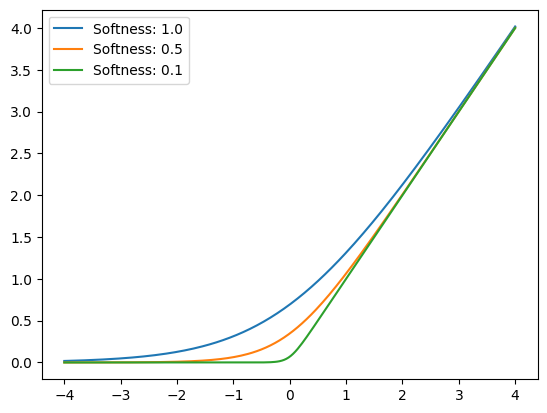

In [67]:
lines = plt.plot(np.tile(xs, 3), ys)
for line, hs in zip(lines, softplus.hinge_softness):
  line.set_label("Softness: %1.1f" % hs)
plt.legend()
plt.show()

Caching

In [69]:
# This bijector represents a matrix outer product on the forward pass,
# and a cholesky decomposition on the inverse pass. The latter costs O(N^3)!
bij = tfp.bijectors.CholeskyOuterProduct()

size = 2500
# Make a big, lower-triangular matrix
big_lower_triangular = tf.eye(size)
# Squaring it gives us a positive-definite matrix
big_positive_definite = bij.forward(big_lower_triangular)

# Caching for the win!
%timeit bij.inverse(big_positive_definite)
%timeit tf.linalg.cholesky(big_positive_definite)

178 µs ± 13.2 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
6.34 ms ± 812 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Markov Chain Monte Carlo: MCMC

Generate Data

In [ ]:
def f(x, w):
    x = tf.pad(x, [[1,0], [0,0]], constant_values=1)